Residual Networks, introduced by He et al., allow you to train much deeper networks than were previously feasible.


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

/Users/olaoluadisa/Documents/WEBDEV1/webdev/code files/codefiles/MLspecial/MLSpe_venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.python.framework.ops import EagerTensor
import scipy.misc
from matplotlib.pyplot import imshow
import os
import h5py
import math
from resnets_utils import *
from keras.layers import Layer
%matplotlib inline

/var/folders/hf/81yfsz694rx2svmh31g42bb80000gn/T/ipykernel_97447/2629762872.py:6: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


ResNet blocks with the shortcut makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance (slow speed due to vanishing gradient). There is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

## The Identity Block

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">

Can also skip over multiple layers

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

In [3]:
def identity_block(X, f, filters,training=False, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 2 above
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
   # Retrieve Filters
    F1, F2, F3 = filters
   
    # Save the input value (shortcut)
    X_shortcut = X
   
    # First component of main path
    X = tf.keras.layers.Conv2D(
        filters=F1, kernel_size=1, strides=(1,1), padding='valid',
        kernel_initializer=initializer(seed=0)
    )(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
    X = tf.keras.layers.Activation('relu')(X)
   
    # Second component of main path
    X = tf.keras.layers.Conv2D(
        filters=F2, kernel_size=f, strides=(1,1), padding='same',
        kernel_initializer=initializer(seed=0)
    )(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
    X = tf.keras.layers.Activation('relu')(X)
  
    # Third component of main path
    X = tf.keras.layers.Conv2D(
        filters=F3, kernel_size=1, strides=(1,1), padding='valid',
        kernel_initializer=initializer(seed=0)
    )(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X, training=training)
  
    # Final step: Add shortcut + main path, then ReLU
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [4]:
# Testing the identity block

np.random.seed(1)
tf.random.set_seed(2)

X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3
X = np.concatenate((X1, X2, X3), axis=0).astype(np.float32)

print('\033[1mWith training=False\033[0m\n')
A3 = identity_block(X, f=2, filters=[4, 4, 3],
                    training=False,                                    # ← important
                    initializer=lambda seed=0: tf.keras.initializers.Constant(value=1))

A3np = A3.numpy()
print(np.around(A3.numpy()[:, (0,-1), :, :].mean(axis=3), 5))
resume = A3np[:, (0,-1), :, :].mean(axis=3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                    training=True,                                     # ← important
                    initializer=lambda seed=0: tf.keras.initializers.Constant(value=1))

print(np.around(A4.numpy()[:, (0,-1), :, :].mean(axis=3), 5))


With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71236 192.71236 192.71236  96.85619]
  [ 96.85619  96.85619  96.85619  48.9281 ]]

 [[578.1371  578.1371  578.1371  290.56854]
  [290.56854 290.56854 290.56854 146.78427]]]
96.85619

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.99991 4.99991 4.99991 3.25948]
  [3.25948 3.25948 3.25948 2.40739]]]


## The Convolutional Block


You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path (does not use any non-linear activation function): The CONV2D layer in the shortcut path is simply used to resize the input  𝑥 to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

In [5]:
def convolutional_block(X, f, filters, s = 2, training=False, 
                        initializer=tf.keras.initializers.glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 3
    """
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding = 'valid',
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)   # ← critical line
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding = 'same',
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)   # ← critical
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding = 'valid',
               kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)   # ← critical
    # NO ReLU here

    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding = 'valid',
                        kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)   # ← critical

    # Final step: Add shortcut to main path, then ReLU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Building a 50 Layer ResNet Model

The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window (pool_size) of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.


In [6]:
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """
   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
   
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
   
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2 ── convolutional block uses glorot, identity blocks use random_uniform
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1, 
                            training=training,
                            initializer=glorot_uniform)

    X = identity_block(X, 3, [64, 64, 256], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [64, 64, 256], training=training,
                       initializer=random_uniform)

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2, 
                            training=training,
                            initializer=glorot_uniform)

    X = identity_block(X, 3, [128, 128, 512], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [128, 128, 512], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [128, 128, 512], training=training,
                       initializer=random_uniform)

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2, 
                            training=training,
                            initializer=glorot_uniform)

    X = identity_block(X, 3, [256, 256, 1024], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [256, 256, 1024], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [256, 256, 1024], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [256, 256, 1024], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [256, 256, 1024], training=training,
                       initializer=random_uniform)

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2, 
                            training=training,
                            initializer=glorot_uniform)

    X = identity_block(X, 3, [512, 512, 2048], training=training,
                       initializer=random_uniform)
    X = identity_block(X, 3, [512, 512, 2048], training=training,
                       initializer=random_uniform)

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2))(X)
   
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', 
              kernel_initializer = glorot_uniform(seed=0))(X)
   
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    return model

In [7]:
#tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 15, 15,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │     36,928 │ activation_7[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 15, 15,    │     16,640 │ activation_8[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 15, 15,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [8]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#The model is now ready to be trained. The only thing you need now is a dataset!

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 519ms/step - accuracy: 0.3120 - loss: 1.8203
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 498ms/step - accuracy: 0.5889 - loss: 1.0549
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 506ms/step - accuracy: 0.8028 - loss: 0.5390
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 512ms/step - accuracy: 0.9074 - loss: 0.2669
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 575ms/step - accuracy: 0.9481 - loss: 0.1404
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 518ms/step - accuracy: 0.9731 - loss: 0.0846
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 542ms/step - accuracy: 0.9306 - loss: 0.1880
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 560ms/step - accuracy: 0.9222 - loss: 0.2069
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 532ms/step - accuracy: 0.9176 - loss: 0.2127
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 532ms/step - accuracy: 0.9389 - loss: 0.1811


In [11]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.4167 - loss: 1.9186
Loss = 1.918561339378357
Test Accuracy = 0.4166666567325592


Test accuracy may seem low. But, It tends to get much better performance when trained for ~20 epochs, but this does take more than an hour when training on a CPU.


**What you should remember**:

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.  
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main types of blocks: The **identity block** and the **convolutional block**. 
- Very deep Residual Networks are built by stacking these blocks together.


## Running a Pretrained Model

In [12]:
pre_trained_model = load_model('./models/resnet50.h5')  #from tensorflow.keras.models import Model, load_model
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

/Users/olaoluadisa/Documents/WEBDEV1/webdev/code files/codefiles/MLspecial/MLSpe_venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9500 - loss: 0.1596
Loss = 0.15958669781684875
Test Accuracy = 0.949999988079071


In [14]:
pre_trained_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 70, 70, 3) │          0 │ input_1[0][0]     │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 32, 32,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 15, 15,    │     36,928 │ activation_7[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 15, 15,    │     16,640 │ activation_8[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 15, 15,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 23,600,008 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

Input image shape: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[9.3347204e-05 4.2750787e-02 9.2499936e-01 4.2042273e-04 3.1700138e-02
  3.5936322e-05]]
Class: 2


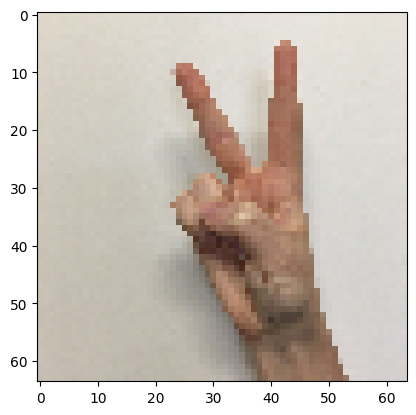

In [13]:
# Run this cell to test the model with your own image

# Replace this with your image's filename
img_path = 'images/sign2.jpg'

img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x 
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))